In [64]:
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt

class ReducedKMeans:
    def __init__(self, n_clusters=3, n_components=2, max_iters=100, tol=1e-5, random_state=None):
        self.n_clusters = n_clusters
        self.n_components = n_components
        self.max_iters = max_iters
        self.tol = tol
        self.objective_history = []
        self.random_state = random_state

        self.P = None  # d × q
        self.Z = None  # n × K
        self.C = None  # K × q
        self.objective_history = []

    def _kmeans_plusplus_init(self, X_proj, K):
        n_samples = X_proj.shape[0]
        centers = []
        idx = np.random.randint(n_samples)
        centers.append(X_proj[idx])

        for _ in range(1, K):
            dist_sq = np.min([np.sum((X_proj - c) ** 2, axis=1) for c in centers], axis=0)
            probs = dist_sq / np.sum(dist_sq)
            cumulative_probs = np.cumsum(probs)
            r = np.random.rand()
            next_idx = np.searchsorted(cumulative_probs, r)
            centers.append(X_proj[next_idx])

        return np.array(centers)

    def _update_centroids(self, X_proj, Z):
        Z_sum = Z.sum(axis=0)
        return (Z.T @ X_proj) / Z_sum[:, np.newaxis]

    def _update_Z(self, X_proj, C):
        distances = np.linalg.norm(X_proj[:, np.newaxis, :] - C[np.newaxis, :, :], axis=2)
        labels = np.argmin(distances, axis=1)
        Z = np.zeros((X_proj.shape[0], self.n_clusters))
        Z[np.arange(X_proj.shape[0]), labels] = 1
        return Z

    def _update_projection(self, X, Z, C):
        W = Z @ C
        M = X.T @ W
        U, _, Vt = svd(M, full_matrices=False)
        return U @ Vt

    def _compute_objective(self, X):
        X_hat = self.Z @ self.C @ self.P.T
        return np.linalg.norm(X - X_hat, 'fro') ** 2/(np.linalg.norm(X, 'fro')**2)

    def fit(self, X, random_state=None):
        if random_state is not None: # 明示的にシードを指定した場合（ex. 多重スタートの場合）ここに値が入る。そうでない場合(=elseブロック)は、インスタンスの初期化時に指定したseedが指定される。
            np.random.seed(random_state) # 多重スタート用
        else:
            np.random.seed(self.random_state)


        n_samples, d = X.shape
        q = self.n_components
        K = self.n_clusters

        self.P = np.linalg.qr(np.random.randn(d, q))[0]
        X_proj = X @ self.P
        self.C = self._kmeans_plusplus_init(X_proj, K)
        self.Z = self._update_Z(X_proj, self.C)

        prev_obj = None
        self.objective_history = []

        for iteration in range(self.max_iters):
            X_proj = X @ self.P
            self.C = self._update_centroids(X_proj, self.Z)
            Z_new = self._update_Z(X_proj, self.C)
            P_new = self._update_projection(X, Z_new, self.C)

            self.Z = Z_new
            self.P = P_new

            obj = self._compute_objective(X)
            self.objective_history.append(obj)

            if prev_obj is not None and abs(prev_obj - obj) < self.tol:
                print(f"収束しました (iter={iteration})")
                break

            prev_obj = obj

        return self

    def fit_multiple_starts(self, X, n_init=10):
        best_obj = np.inf
        best_result = None
        all_objectives = []

        for i in range(n_init):
            random_state = None if self.random_state is None else self.random_state + i
            self.fit(X, random_state=random_state)
            final_obj = self.objective_history[-1]
            all_objectives.append(final_obj)
            if final_obj < best_obj:
                best_obj = final_obj
                best_result = {
                    "membership_matrix": self.Z.copy(),
                    "centroids": self.C.copy(),
                    "projection": self.P.copy(),
                    "objective_history": self.objective_history.copy(),
                }

        # 最良解をセット
        self.Z = best_result["membership_matrix"]
        self.C = best_result["centroids"]
        self.P = best_result["projection"]
        self.objective_history = best_result["objective_history"]

        return self

    def predict(self, X):
        X_proj = X @ self.P
        distances = np.linalg.norm(X_proj[:, np.newaxis, :] - self.C[np.newaxis, :, :], axis=2)
        return np.argmin(distances, axis=1)

    def transform(self, X):
        return X @ self.P

    def plot_objective(self):
        if not self.objective_history:
            print("fit() を先に実行してください。")
            return
        plt.plot(self.objective_history, marker='o')
        plt.xlabel("Iteration")
        plt.ylabel("Objective (Frobenius norm squared)")
        plt.title("Objective Function Over Iterations")
        plt.grid(True)
        plt.show()


In [65]:
np.random.seed(13)
X = np.random.randn(500, 20)

model1 = ReducedKMeans(n_clusters=5, n_components=3, tol=1e-8, random_state=123)
model1.fit(X)

model2 = ReducedKMeans(n_clusters=5, n_components=3, tol=1e-8, random_state=123)
model2.fit(X)

np.allclose(model1.Z, model2.Z)  # True が期待される


収束しました (iter=36)
収束しました (iter=36)


True

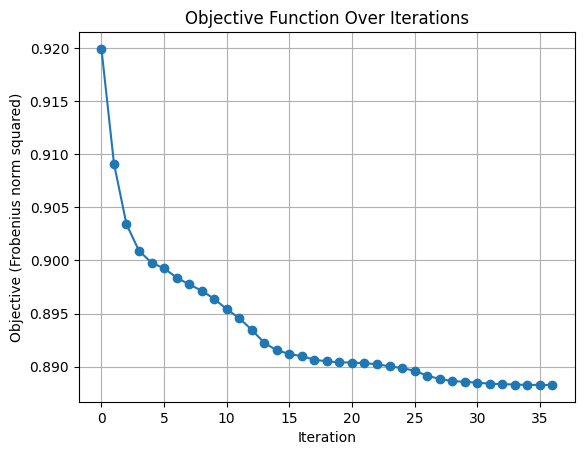

In [66]:
model1.plot_objective()

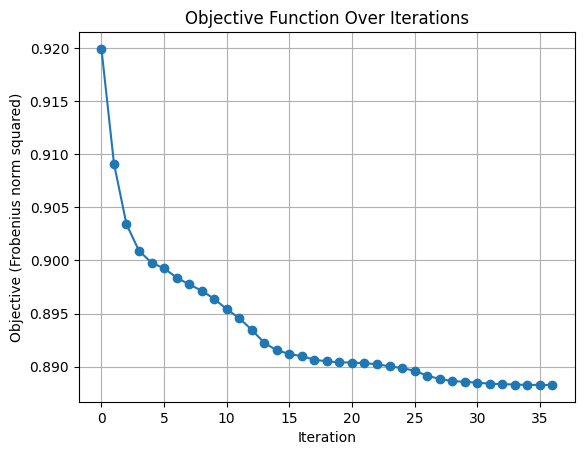

In [67]:
model2.plot_objective()

In [68]:
model1.C

array([[ 1.38595344, -0.44731366,  0.59999172],
       [-1.69845156,  0.3663119 , -0.15468024],
       [ 0.43787904,  0.77138669, -1.01212725],
       [-0.24766184,  0.5817572 ,  1.30826672],
       [-0.37336961, -1.34229881, -0.37674735]])

収束しました (iter=36)
収束しました (iter=14)
収束しました (iter=28)
収束しました (iter=29)
収束しました (iter=25)
収束しました (iter=29)
収束しました (iter=22)
収束しました (iter=30)
収束しました (iter=40)
収束しました (iter=22)


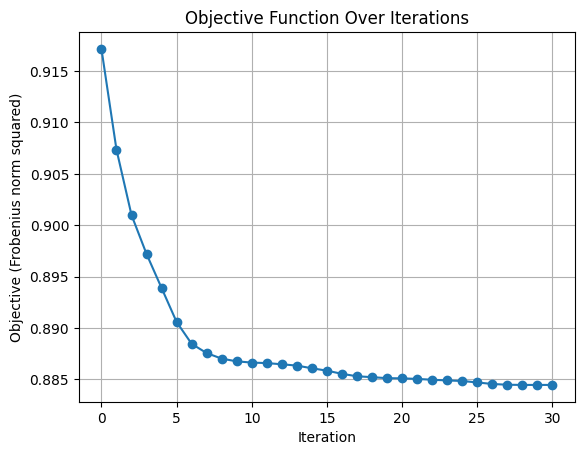

In [69]:
rkm = ReducedKMeans(n_clusters=5, n_components=3, tol=1e-8, random_state=123)
rkm.fit_multiple_starts(X, n_init=10)
rkm.plot_objective()

収束しました (iter=5)


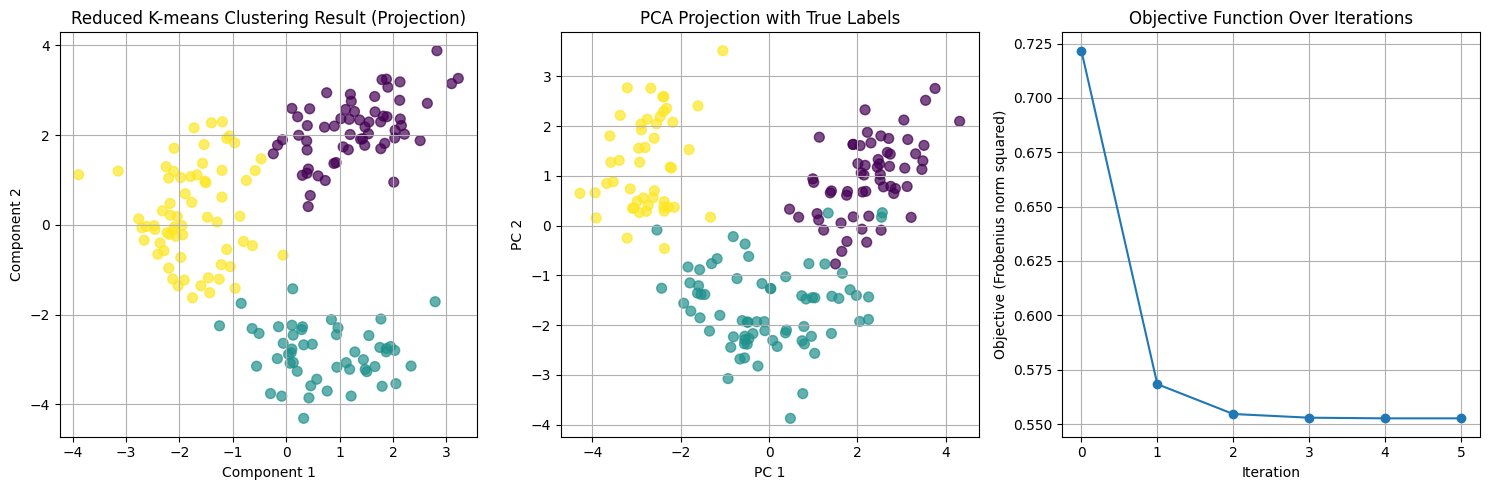

In [70]:
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# データロード
data = load_wine()
X = data.data      # shape (178, 13)
sc = StandardScaler()
X = sc.fit_transform(X)
y_true = data.target

# ReducedKMeans クラスのインスタンス化
rkm = ReducedKMeans(n_clusters=3, n_components=2, max_iters=100, tol=1e-5, random_state=42)

# 学習
rkm.fit(X)

# クラスタリング結果のラベル予測
labels = rkm.predict(X)

# 射影した低次元データを取得
X_proj = rkm.transform(X)  # shape (178, 2)

# PCAで比較用に2次元に射影（視覚化補助）
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 可視化
plt.figure(figsize=(15, 5))

# Reduced K-means のクラスタリング結果（射影空間で）
plt.subplot(1, 3, 1)
plt.scatter(X_proj[:, 0], X_proj[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
plt.title("Reduced K-means Clustering Result (Projection)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)

# PCAによる2次元射影の結果（ラベルは真値）
plt.subplot(1, 3, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_true, cmap='viridis', s=50, alpha=0.7)
plt.title("PCA Projection with True Labels")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)

# 目的関数の減少
plt.subplot(1, 3, 3)
plt.plot(rkm.objective_history, marker='o')
plt.title("Objective Function Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Objective (Frobenius norm squared)")
plt.grid(True)

plt.tight_layout()
plt.show()

# 大規模な人工データでの例

収束しました (iter=22)
Reduced K-means fit time: 0.161 seconds


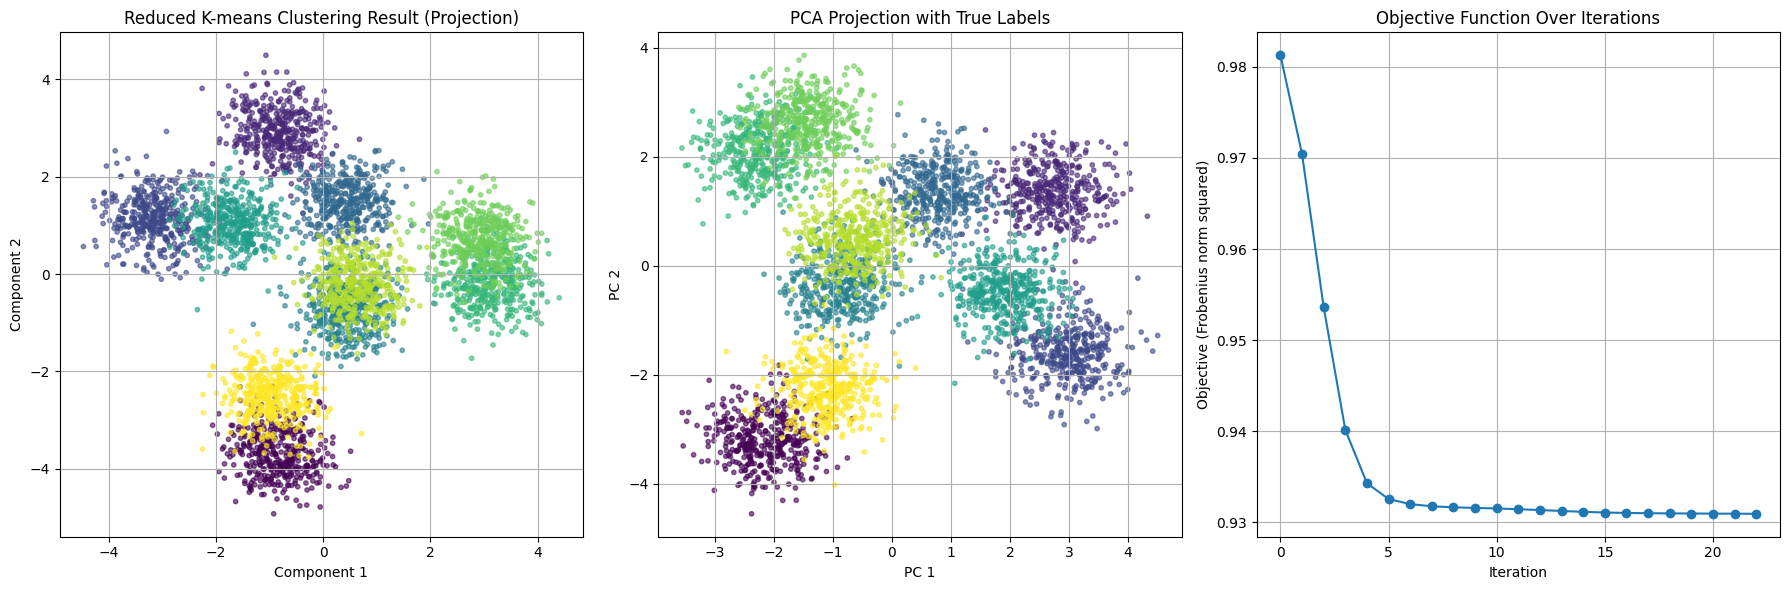

In [71]:
import time # 時間計測用

def generate_high_dim_clustered_data(n_samples=4000, n_features=50, n_informative=5, n_clusters=3, cluster_std=1.0, random_state=42):
    np.random.seed(random_state)

    samples_per_cluster = n_samples // n_clusters
    remainder = n_samples % n_clusters  # 余り

    X_informative = []
    y = []
    centers = np.random.uniform(-10, 10, size=(n_clusters, n_informative))

    for k in range(n_clusters):
        # 最後のクラスタに余りを足す
        n_k = samples_per_cluster + (1 if k == n_clusters - 1 else 0) * remainder
        cluster_points = centers[k] + np.random.randn(n_k, n_informative) * cluster_std
        X_informative.append(cluster_points)
        y.extend([k]*n_k)

    X_informative = np.vstack(X_informative)
    y = np.array(y)

    noise = np.random.randn(n_samples, n_features - n_informative) * 0.1

    X = np.hstack([X_informative, noise])

    perm = np.random.permutation(n_features)
    X = X[:, perm]

    return X, y



# パラメータ設定
n_samples = 4000
n_features = 100
n_informative = 20
n_clusters = 10

# データ生成
X, y_true = generate_high_dim_clustered_data(n_samples=n_samples, n_features=n_features,
                                              n_informative=n_informative, n_clusters=n_clusters,
                                              cluster_std=3, random_state=42)

sc = StandardScaler()
X = sc.fit_transform(X)

# モデル初期化
rkm = ReducedKMeans(n_clusters=n_clusters, n_components=2, max_iters=100, tol=1e-5, random_state=42)

# 学習時間計測
start = time.time()
rkm.fit(X)
elapsed = time.time() - start
print(f"Reduced K-means fit time: {elapsed:.3f} seconds")

# 予測ラベル
labels = rkm.predict(X)

# 射影データ取得
X_proj = rkm.transform(X)

# PCAでも2次元に射影して比較
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# 可視化
plt.figure(figsize=(18, 6))

# ReducedKMeansクラスタ結果 (射影空間)
plt.subplot(1, 3, 1)
plt.scatter(X_proj[:, 0], X_proj[:, 1], c=y_true, cmap='viridis', s=10, alpha=0.6)
plt.title("Reduced K-means Clustering Result (Projection)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)

# PCA射影 & 正解ラベル
plt.subplot(1, 3, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_true, cmap='viridis', s=10, alpha=0.6)
plt.title("PCA Projection with True Labels")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)

# 目的関数の減少
plt.subplot(1, 3, 3)
plt.plot(rkm.objective_history, marker='o')
plt.title("Objective Function Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Objective (Frobenius norm squared)")
plt.grid(True)

plt.tight_layout()
plt.show()